# Imports

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from time import time

from torchvision import datasets
from torchvision.transforms import ToTensor

from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

# Load dataset

In [2]:
def load_mnist(batch_size):

    root = "C:/Users/edvin/GitHub/DeepImg/A3/MNIST/"
    
    # Load the dataset
    train_data = datasets.MNIST(root+"Train", train=True, download=False, transform=ToTensor())
    test_data = datasets.MNIST(root+"Test", train=False, download=False, transform=ToTensor())

    # Create dataloaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

    return train_loader, test_loader

In [3]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(train_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")
    
    break

data.shape: torch.Size([100, 1, 28, 28])

  Nr of images: 100
  Channels: 1
  Width: 28
  Height: 28


In [4]:
train_loader, test_loader = load_mnist(100)
for batch_idx, (data, labels) in enumerate(test_loader):
    
    print(f"data.shape: {data.shape}\n")
    
    print(f"  Nr of images: {data.shape[0]}")
    print(f"  Channels: {data.shape[1]}")
    print(f"  Width: {data.shape[2]}")
    print(f"  Height: {data.shape[3]}")

data.shape: torch.Size([10000, 1, 28, 28])

  Nr of images: 10000
  Channels: 1
  Width: 28
  Height: 28


# Define Default Network (for momentum and L2)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        # Layer 1
        Z1 = self.conv1(X)
        A1 = self.relu(Z1)
        
        # Layer 2
        A2 = self.maxpool(A1)
        
        # Layer 3
        Z3 = self.conv2(A2)
        A3 = self.relu(Z3)
        
        # Layer 4
        A4 = self.maxpool(A3)
        
        # Layer 5
        Z5 = self.conv3(A4)
        A5 = self.relu(Z5)
        A5 = A5.reshape(A5.size(0), -1)  # Flatten

        # Layer 6
        Z6 = self.W6(A5)
        Y_hat = self.softmax(Z6)

        return Y_hat

# Accuracy function

In [6]:
def get_accuracy(output,labels):
    # How many data points
    n = labels.size(0)
    
    # Get model predictions
    _, predictions = torch.max(output, 1)
    
    # Vector of "True" or "False" if prediction matches true labels
    correct = (predictions == labels)
    
    # Count how many "True"
    total_correct = correct.sum().item()
    
    # Calculate accuracy
    acc = total_correct / n
    
    return acc

In [7]:
def test_accuracy(test_loader,model,device):
    # Load data and labels
    for data, labels in test_loader:  # Test_loader is one batch of all test data
        data = data.to(device)
        labels = labels.to(device)
    
    # Feed into model
    output = model(data).to(device)
    
    # Get accuracy by comparing output and labels
    acc_test = get_accuracy(output,labels) 
    
    return acc_test

# Define training loop

In [8]:
def train_model(train_loader,test_loader,learning_rate, epochs, device, loss_vec, acc_train_vec, acc_test_vec):
    
    # Define model
    model = CNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Performance with random weights
    test_acc = test_accuracy(test_loader,model,device)
    print(f'Epoch [0/{epochs}],                                  , Test Acc: {test_acc:.5f}')
    
    # Training loop
    for epoch in range(1,epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss every 100 batches
            if idx%100==0:
                loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        acc_train = get_accuracy(output,labels)
        acc_train_vec.append(acc_train)
        
        # Accuracy on all test data
        acc_test = test_accuracy(test_loader,model,device)  
        acc_test_vec.append(acc_test)
            
        # Print epoch results
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train Acc: {acc_train:.5f}, Test Acc: {acc_test:.5f}')
    
    return model

# Train SGD with momentum=0.9

In [9]:
# Hyperparameters
batch_size = 100
learning_rate = 0.05
epochs = 15

# List for storing loss
momentum_loss_vec = []
momentum_acc_train_vec = []
momentum_acc_test_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,momentum_loss_vec, momentum_acc_train_vec, momentum_acc_test_vec)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.09270
Epoch [1/15], Loss: 1.52724, Train Acc: 0.94000, Test Acc: 0.94820
Epoch [2/15], Loss: 1.49269, Train Acc: 0.97000, Test Acc: 0.96160
Epoch [3/15], Loss: 1.48226, Train Acc: 0.98000, Test Acc: 0.97460
Epoch [4/15], Loss: 1.47819, Train Acc: 0.98000, Test Acc: 0.97000
Epoch [5/15], Loss: 1.49116, Train Acc: 0.97000, Test Acc: 0.97840
Epoch [6/15], Loss: 1.48116, Train Acc: 0.98000, Test Acc: 0.98070
Epoch [7/15], Loss: 1.48327, Train Acc: 0.98000, Test Acc: 0.98370
Epoch [8/15], Loss: 1.49469, Train Acc: 0.96000, Test Acc: 0.98170
Epoch [9/15], Loss: 1.49637, Train Acc: 0.96000, Test Acc: 0.98230
Epoch [10/15], Loss: 1.48144, Train Acc: 0.98000, Test Acc: 0.98640
Epoch [11/15], Loss: 1.46116, Train Acc: 1.00000, Test Acc: 0.98590
Epoch [12/15], Loss: 1.47059, Train Acc: 0.99000, Test Acc: 0.98400
Epoch [13/15], Loss: 1.48452, Train Acc: 0.98000, Test Acc: 0.98530
Epoch [14/15], Loss: 1.48264, Train Acc

# Train with L2 regularizaiton = 0.0001

In [10]:
def train_model(train_loader,test_loader,learning_rate, epochs, device, loss_vec, acc_train_vec, acc_test_vec):
    
    # Define model
    model = CNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    
    # Performance with random weights
    test_acc = test_accuracy(test_loader,model,device)
    print(f'Epoch [0/{epochs}],                                  , Test Acc: {test_acc:.5f}')
    
    # Training loop
    for epoch in range(1,epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss every 100 batches
            if idx%100==0:
                loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        acc_train = get_accuracy(output,labels)
        acc_train_vec.append(acc_train)
        
        # Accuracy on all test data
        acc_test = test_accuracy(test_loader,model,device)  
        acc_test_vec.append(acc_test)
            
        # Print epoch results
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train Acc: {acc_train:.5f}, Test Acc: {acc_test:.5f}')
    
    return model

In [11]:
# Hyperparameters
batch_size = 100
learning_rate = 0.05
epochs = 15

# List for storing loss
l2_loss_vec = []
l2_acc_train_vec = []
l2_acc_test_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,l2_loss_vec,l2_acc_train_vec,l2_acc_test_vec)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.10950
Epoch [1/15], Loss: 1.76834, Train Acc: 0.70000, Test Acc: 0.70310
Epoch [2/15], Loss: 1.69857, Train Acc: 0.76000, Test Acc: 0.75450
Epoch [3/15], Loss: 1.64596, Train Acc: 0.82000, Test Acc: 0.84040
Epoch [4/15], Loss: 1.65715, Train Acc: 0.80000, Test Acc: 0.85030
Epoch [5/15], Loss: 1.55228, Train Acc: 0.91000, Test Acc: 0.85890
Epoch [6/15], Loss: 1.64607, Train Acc: 0.81000, Test Acc: 0.86600
Epoch [7/15], Loss: 1.64036, Train Acc: 0.81000, Test Acc: 0.86710
Epoch [8/15], Loss: 1.60108, Train Acc: 0.86000, Test Acc: 0.87800
Epoch [9/15], Loss: 1.61940, Train Acc: 0.84000, Test Acc: 0.87890
Epoch [10/15], Loss: 1.62102, Train Acc: 0.85000, Test Acc: 0.88260
Epoch [11/15], Loss: 1.61139, Train Acc: 0.85000, Test Acc: 0.87570
Epoch [12/15], Loss: 1.55170, Train Acc: 0.91000, Test Acc: 0.88180
Epoch [13/15], Loss: 1.57042, Train Acc: 0.89000, Test Acc: 0.88630
Epoch [14/15], Loss: 1.54379, Train Acc

# Train with Dropout Layer = 0.5

In [12]:
def train_model(train_loader,test_loader,learning_rate, epochs, device, loss_vec, acc_train_vec, acc_test_vec):
    
    # Define model
    model = CNN().to(device)  # Select model and move to "device"
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    # Performance with random weights
    test_acc = test_accuracy(test_loader,model,device)
    print(f'Epoch [0/{epochs}],                                  , Test Acc: {test_acc:.5f}')
    
    # Training loop
    for epoch in range(1,epochs+1):
        for idx, (data, labels) in enumerate(train_loader):
            # Move to "device"
            data = data.to(device)
            labels = labels.to(device)
            
            # Model forward and backward
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss every 100 batches
            if idx%100==0:
                loss_vec.append(loss.item())
            
        # Accuracy on last mini-batch of train data
        acc_train = get_accuracy(output,labels)
        acc_train_vec.append(acc_train)
        
        # Accuracy on all test data
        acc_test = test_accuracy(test_loader,model,device)  
        acc_test_vec.append(acc_test)
            
        # Print epoch results
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.5f}, Train Acc: {acc_train:.5f}, Test Acc: {acc_test:.5f}')
    
    return model

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Layer 1:   8 filters with dim=3x3x1  ->  dim(Z1) = 28x28x8
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1) 
        
        # Layer 2: Max Pooling with dim=2x2    ->  dim(Z2) = 14x14x8
        
        # Layer 3:   16 filters with dim=3x3x8  ->  dim(Z3) = 14x14x16
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # 16 filters: 3x3x8 ->
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Layer 4: Max Pooling with dim=2x2    ->  dim(Z4) = 7x7x16
        
        # Layer 5: 32 filters with dim=3x3x16  ->  dim(Z5) =  7x7x32
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) 
        
        # Layer 6: Fully connected with dim=1568x10  ->  dim(Z6) = 1x10
        self.W6 = nn.Linear(7 * 7 * 32, 10)   

        # Define activation functions
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        # Layer 1
        Z1 = self.conv1(X)
        A1 = self.relu(Z1)
        
        # Layer 2
        A2 = self.maxpool(A1)
        
        # Layer 3
        Z3 = self.conv2(A2)
        A3 = self.relu(Z3)
        
        # Dropout
        A3 = self.dropout(A3)
        
        # Layer 4
        A4 = self.maxpool(A3)
        
        # Layer 5
        Z5 = self.conv3(A4)
        A5 = self.relu(Z5)
        A5 = A5.reshape(A5.size(0), -1)  # Flatten

        # Layer 6
        Z6 = self.W6(A5)
        Y_hat = self.softmax(Z6)

        return Y_hat

In [15]:
# Hyperparameters
batch_size = 100
learning_rate = 0.05
epochs = 15

# List for storing loss
dropout_loss_vec = []
dropout_acc_train_vec = []
dropout_acc_test_vec = []

# Select where to train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on: {device}\n")

# Load data
train_loader,test_loader = load_mnist(batch_size)

# Train model
start = time()
model = train_model(train_loader, test_loader, learning_rate, epochs,device,dropout_loss_vec, dropout_acc_train_vec, dropout_acc_test_vec)
print(f"\nTotal training time: {time()-start} seconds")


Training on: cuda

Epoch [0/15],                                  , Test Acc: 0.11500
Epoch [1/15], Loss: 1.68185, Train Acc: 0.81000, Test Acc: 0.80200
Epoch [2/15], Loss: 1.62456, Train Acc: 0.84000, Test Acc: 0.82040
Epoch [3/15], Loss: 1.59576, Train Acc: 0.88000, Test Acc: 0.84080
Epoch [4/15], Loss: 1.66820, Train Acc: 0.81000, Test Acc: 0.85030
Epoch [5/15], Loss: 1.56422, Train Acc: 0.90000, Test Acc: 0.86170
Epoch [6/15], Loss: 1.56544, Train Acc: 0.89000, Test Acc: 0.86890
Epoch [7/15], Loss: 1.62928, Train Acc: 0.82000, Test Acc: 0.87220
Epoch [8/15], Loss: 1.62405, Train Acc: 0.84000, Test Acc: 0.87100
Epoch [9/15], Loss: 1.59796, Train Acc: 0.86000, Test Acc: 0.87440
Epoch [10/15], Loss: 1.58743, Train Acc: 0.87000, Test Acc: 0.87660
Epoch [11/15], Loss: 1.58492, Train Acc: 0.87000, Test Acc: 0.87710
Epoch [12/15], Loss: 1.60091, Train Acc: 0.86000, Test Acc: 0.87910
Epoch [13/15], Loss: 1.58396, Train Acc: 0.89000, Test Acc: 0.88140
Epoch [14/15], Loss: 1.53550, Train Acc

# Print loss

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

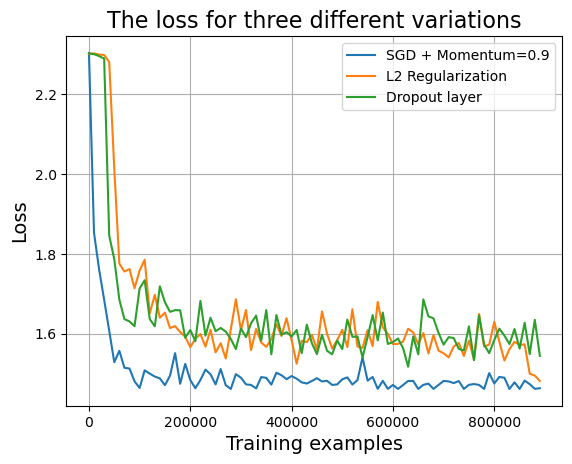

In [16]:
# Set the plot style
plt.style.use('default')

# Define data
x1 = range(0, len(momentum_loss_vec) * batch_size*100, batch_size*100)
y1 = momentum_loss_vec

x2 = range(0, len(l2_loss_vec) * batch_size*100, batch_size*100)
y2 = l2_loss_vec

x3 = range(0, len(dropout_loss_vec) * batch_size*100, batch_size*100)
y3 = dropout_loss_vec


# Clear current plot
plt.clf()


# Define figure
fig1 = plt.figure()

plt.plot(x1,y1, label="SGD + Momentum=0.9")
plt.plot(x2,y2, label="L2 Regularization")
plt.plot(x3,y3, label="Dropout layer")

plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Loss", fontsize=14) 
plt.legend()
plt.grid()
plt.title("The loss for three different variations", fontsize=16) 
plt.savefig("CNN_variations_loss.eps")
plt.show()

# Print accuracy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 640x480 with 0 Axes>

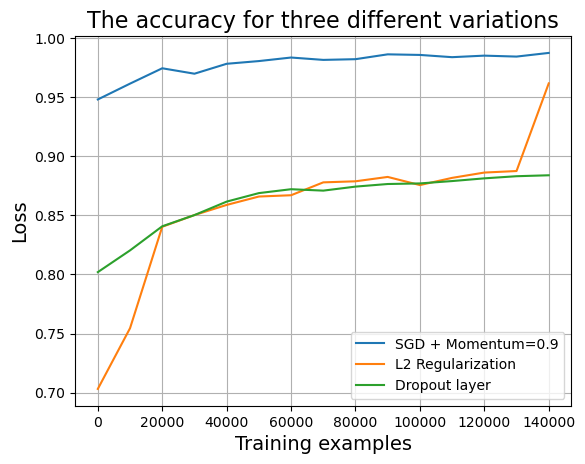

In [19]:
# Set the plot style
plt.style.use('default')

# Define data
x1 = range(0, len(momentum_acc_test_vec)*10000, 10000)
y1 = momentum_acc_test_vec

x2 = range(0, len(l2_acc_test_vec)*10000, 10000)
y2 = l2_acc_test_vec

x3 = range(0, len(dropout_acc_test_vec)*10000, 10000)
y3 = dropout_acc_test_vec


# Clear current plot
plt.clf()


# Define figure
fig1 = plt.figure()

plt.plot(x1,y1, label="SGD + Momentum=0.9")
plt.plot(x2,y2, label="L2 Regularization")
plt.plot(x3,y3, label="Dropout layer")

plt.xlabel("Training examples", fontsize=14)
plt.ylabel("Loss", fontsize=14) 
plt.legend()
plt.grid()
plt.title("The accuracy for three different variations", fontsize=16) 
plt.savefig("CNN_variations_loss.eps")
plt.show()